###### Install missing package ######
!pip install duckdb
!pip install matplotlib

#### Récupérer les données depuis l'API de l'insee (MELODI)

In [7]:
import requests
import json
import pandas as pd
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


server = "https://api.insee.fr/melodi"

#### Retreive all catalogs #####

res = requests.get(f"{server}/catalog/all")

for r in res.json():
    print(r["identifier"], r["title"][0]["content"])

DD_CNA_AGREGATS Produit Intérieur Brut (PIB) et grands agrégats économiques
DD_CNA_APU Comptes des administrations publiques
DD_CNA_BRANCHES Activité des branches de l'économie
DD_CNA_CONSO_MENAGES_COICOP Consommation des ménages par fonction
DD_CNA_CONSO_MENAGES_PRODUITS Consommation des ménages par produit
DD_CNA_ECH_EXT Échanges extérieurs
DD_CNA_PATRIMOINE Comptes de patrimoine
DD_CNA_PATRIMOINE_BRANCHES Comptes de patrimoine par branches
DD_CNA_TEE Tableau économique d'ensemble
DD_EEC_ANNUEL Activité, emploi et chômage - résultats annuels 2023
DD_EEC_SERIES Activité, emploi et chômage - séries longues
DS_ANTIPOL Enquête annuelle sur les investissements pour protéger l'environnement (Antipol)
DS_BPE Dénombrement des équipements (commerce, sport, services, santé…)
DS_BPE_EDUCATION Enseignement : dénombrement et caractéristiques des équipements
DS_BPE_EVOLUTION Évolution du nombre d'équipements et services
DS_BPE_SPORT_CULTURE Sport, loisirs et culture : dénombrement, caractéristique

In [3]:
####### Select population Data set #####

catalogs_ids = ["DS_RP_POPULATION_COMP"]

# Afficher les métadonnées liées aux différents 
for cid in catalogs_ids:
    url = f"{server}/catalog/{cid}"
    res = requests.get(url)
    print(res.json())

{'identifier': 'DS_RP_POPULATION_COMP', 'title': [{'lang': 'fr', 'content': 'Population'}, {'lang': 'en', 'content': 'Population'}], 'subtitle': [{'lang': 'fr', 'content': 'Recensement de la population - Exploitation complémentaire'}, {'lang': 'en', 'content': 'Population census - Additional operation'}], 'description': [{'lang': 'fr', 'content': "Les données sont détaillées par sexe, âge (en 3 tranches d'âge) et catégorie socio-professionnelle (PCS). Elles sont fournies à différents niveaux géographiques (commune, arrondissement municipal, arrondissement, département, région, établissement public de coopération intercommunal, unité urbaines 2020, aire d'attraction des villes 2020, bassin de vie 2022, zone d'emploi 2020, France)."}, {'lang': 'en', 'content': 'Data is broken down by gender, age (in 3 age brackets) and socio-professional category (PCS). They are provided at different geographical levels (commune, municipal district, arrondissement, département, region, public inter-commu

In [52]:
#commune = '2024-COM-74010' # Annecy
commune = '2024-COM-69123'  # Lyon

time_period = '2021'
catalog = "DS_RP_POPULATION_COMP"

def getpopulationdata(server, catalog, time_period, commune):
    url = f"{server}/data/{catalog}?TIME_PERIOD={time_period}&GEO={commune}"
    res = requests.get(url)
    data = res.json()

    observations = data["observations"]
    extracted_data = []

    for obs in observations:
        dimensions = obs["dimensions"]

        if 'attributes' in obs:
            attributes = obs["attributes"]
        else:
            attributes = None

        # Suivant les jeux de données value peut être absent
        if 'value' in obs['measures']['OBS_VALUE_NIVEAU']:
            measures = obs['measures']['OBS_VALUE_NIVEAU']['value']
        else:
            measures = None

        # on rassemble tout dans un objet
        if 'attributes' in obs:
            combined_data = {**dimensions,**attributes, 'OBS_VALUE_NIVEAU': measures}
        else:
            combined_data = {**dimensions, 'OBS_VALUE_NIVEAU': measures}
        
        extracted_data.append(combined_data)

    df_data = pd.DataFrame(extracted_data)
    return df_data

In [53]:
###### Load files ######
population_df = getpopulationdata(server, catalog, time_period, commune)
mapping_df = pd.read_csv('mapping.csv')
mapping_geo_df = pd.read_csv('code_geo.csv')
conseillers_df = pd.read_csv('conseillers.csv')

###### DuckDB in-memory connection ######

con = duckdb.connect(database=':memory:')

con.register('population_df', population_df)
con.register('mapping_df', mapping_df)
con.register('conseillers_df', conseillers_df)

con.execute("CREATE TABLE population AS SELECT * FROM population_df WHERE 1 = 1 AND SEX = '_T' AND PCS != '_T'")
con.execute("CREATE TABLE mapping_geo_df AS SELECT * FROM mapping_geo_df")
con.execute("CREATE TABLE mapping AS SELECT * FROM mapping_df")
con.execute("CREATE TABLE conseillers AS SELECT * FROM conseillers_df")


query = """

    WITH aggregated_population AS (
    
        SELECT
            GEO
            , PCS
            , OBS_VALUE_NIVEAU
            , ROUND(SUM(OBS_VALUE_NIVEAU) OVER (PARTITION BY GEO), 0) AS total_population_by_geo
            , ROUND(OBS_VALUE_NIVEAU / SUM(OBS_VALUE_NIVEAU) OVER (PARTITION BY GEO), 4) AS total_population_by_geo_ratio

        FROM population p
        WHERE 1 = 1 AND SEX = '_T' AND PCS != '_T'

    )




    SELECT
        GEO AS geo
        , PCS AS pcs
        , m.description AS pcs_description
        , mapping_geo_df.libelle_francais AS libelle_francais
        , SUM(OBS_VALUE_NIVEAU) AS total_population_by_geo
        , SUM(total_population_by_geo_ratio)  AS total_population_by_geo_ratio
        , SUM(total_population_by_geo_ratio * conseillers.nombre_de_conseillers) AS total_conseiller_by_pcs
        
    FROM aggregated_population p
    LEFT JOIN mapping m ON CAST(p.PCS AS VARCHAR) = CAST(m.id AS VARCHAR)
    LEFT JOIN conseillers ON p.total_population_by_geo BETWEEN population_min AND population_max
    LEFT JOIN mapping_geo_df ON p.GEO = CONCAT('2024-', mapping_geo_df.code_geo) --Dodgy logic to be able to join the geo code with the mapping table
    GROUP BY 1, 2, 3, 4
    """
df = con.execute(query).fetchdf()
df



,geo,pcs,pcs_description,libelle_francais,total_population_by_geo,total_population_by_geo_ratio,total_conseiller_by_pcs
0,2024-COM-69123,4,Professions intermédiaires,Lyon,151277.25430,0.1706,14.1598
1,2024-COM-69123,5,Employés,Lyon,120457.06428,0.1359,11.2797
2,2024-COM-69123,2,Artisans - commerçants et chefs d'entreprise,Lyon,27227.68796,0.0308,2.5564
3,2024-COM-69123,3,Cadres et professions intellectuelles supérieures,Lyon,195878.03878,0.2209,18.3347
4,2024-COM-69123,7,Retraités,Lyon,150333.17106,0.1695,14.0685
5,2024-COM-69123,9,Autres inactifs,Lyon,189856.42098,0.2142,17.7786
6,2024-COM-69123,1,Agriculteurs,Lyon,195.09265,0.0003,0.0249
7,2024-COM-69123,6,Ouvriers,Lyon,51412.87442,0.0580,4.8140


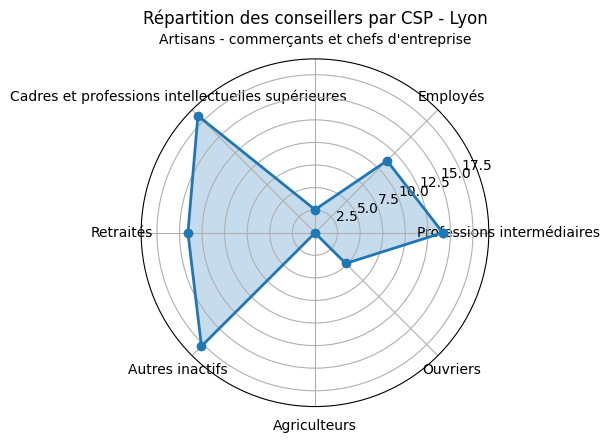

In [54]:

def radar_commune(df, libelle):

    df = df[df['geo'] == libelle]
    labels = df['pcs_description'].tolist()
    values = df['total_conseiller_by_pcs'].tolist()
    city_name = df['libelle_francais'].tolist()
    
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    ax.set_title(f"Répartition des conseillers par CSP - {city_name[0]}")
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    plt.tight_layout()
    plt.show()

# Exemple d’appel
##code_insee = '75056'  # Paris
##result = repartition_conseillers_par_categorie(code_insee)

radar_commune(df, "2024-COM-69123")
